In [2]:
import sqlite3 as sql
import pandas as pd
from datetime import timedelta


In [3]:
myconn = sql.connect("eplusout.sql")
# mycursor = myconn.cursor()

In [4]:
# Executar comando para extraer nombre de variables
comando = "SELECT ReportDataDictionaryIndex, KeyValue, Name, Units FROM ReportDataDictionary"
variables = pd.read_sql_query(comando,con=myconn)
# variables.set_index('ReportDataDictionaryIndex',inplace=True)
variables

,ReportDataDictionaryIndex,KeyValue,Name,Units
0,7,Environment,Site Outdoor Air Drybulb Temperature,C
1,9,,Electricity:Facility,J
2,11,,Electricity:Facility,J
3,961,TZ-D01,Zone Air Temperature,C
4,962,TZ-D01,Zone Air Relative Humidity,%
...,...,...,...,...
72,2093,TZ-D21 IDEAL LOADS AIR SYSTEM,Zone Ideal Loads Zone Total Cooling Rate,W
73,2096,TZ-D25 IDEAL LOADS AIR SYSTEM,Zone Ideal Loads Zone Sensible Cooling Rate,W
74,2097,TZ-D25 IDEAL LOADS AIR SYSTEM,Zone Ideal Loads Zone Total Cooling Rate,W
75,2100,TZ-D27 IDEAL LOADS AIR SYSTEM,Zone Ideal Loads Zone Sensible Cooling Rate,W


In [4]:
# 4. Executar comando para encontrar datos de tiempo
comando = "SELECT tm.TimeIndex, tm.Year, tm.Month, tm.Day, tm.Hour, tm.Minute FROM Time AS tm"
tiempo = pd.read_sql_query(comando,con=myconn)
tiempo = tiempo[tiempo.Year!=0]
tiempo

,TimeIndex,Year,Month,Day,Hour,Minute
169,170,2006,1,1,0,10
170,171,2006,1,1,0,20
171,172,2006,1,1,0,30
172,173,2006,1,1,0,40
173,174,2006,1,1,0,50
...,...,...,...,...,...,...
61496,61497,2006,12,31,23,40
61497,61498,2006,12,31,23,50
61498,61499,2006,12,31,24,0
61499,61500,2006,12,31,24,0


In [5]:
# Executar comando para extraer datos y crear una copia

comando = """SELECT ReportData.TimeIndex, ReportData.ReportDataDictionaryIndex, ReportData.Value
  FROM (ReportData INNER JOIN ReportDataDictionary ON ReportData.ReportDataDictionaryIndex = ReportDataDictionary.ReportDataDictionaryIndex) 
  INNER JOIN Time ON ReportData.TimeIndex = Time.TimeIndex"""
data = pd.read_sql_query(comando,con=myconn)
data


,TimeIndex,ReportDataDictionaryIndex,Value
0,1,2048,3.899745e+03
1,1,2049,7.234953e+03
2,1,2052,1.185320e+03
3,1,2053,1.185320e+03
4,1,2056,1.425413e+03
...,...,...,...
2020694,61500,1762,9.190799e+01
2020695,61500,1801,2.400000e+01
2020696,61500,1802,4.918463e+01
2020697,61500,11,5.860425e+08


In [6]:
datos_variables = pd.merge(data,variables)
datos_variables

,TimeIndex,ReportDataDictionaryIndex,Value,KeyValue,Name,Units
0,1,2048,3899.745066,TZ-D01 IDEAL LOADS AIR SYSTEM,Zone Ideal Loads Zone Sensible Cooling Rate,W
1,2,2048,3689.007241,TZ-D01 IDEAL LOADS AIR SYSTEM,Zone Ideal Loads Zone Sensible Cooling Rate,W
2,3,2048,3479.387742,TZ-D01 IDEAL LOADS AIR SYSTEM,Zone Ideal Loads Zone Sensible Cooling Rate,W
3,4,2048,3270.880041,TZ-D01 IDEAL LOADS AIR SYSTEM,Zone Ideal Loads Zone Sensible Cooling Rate,W
4,5,2048,3063.487429,TZ-D01 IDEAL LOADS AIR SYSTEM,Zone Ideal Loads Zone Sensible Cooling Rate,W
...,...,...,...,...,...,...
2020694,41001,7,23.444668,Environment,Site Outdoor Air Drybulb Temperature,C
2020695,46042,7,23.962141,Environment,Site Outdoor Air Drybulb Temperature,C
2020696,51251,7,24.832953,Environment,Site Outdoor Air Drybulb Temperature,C
2020697,56292,7,24.505718,Environment,Site Outdoor Air Drybulb Temperature,C


In [7]:
datos_variables_tiempo = pd.merge(datos_variables,tiempo)
df = datos_variables_tiempo.copy()
df['fecha'] = pd.to_datetime(df[['Year','Month','Day']])
# agrega un d'ia cuando la hora es 24
df.loc[df.Hour==24,'fecha'] += pd.Timedelta('1D')
# cambia la hora de 24 a 0 
df.loc[df.Hour==24,'Hour'] = 0
# rehace la fecha usando el tiempo
df['fecha'] = pd.to_datetime(df[['Year','Month','Day','Hour','Minute']])
# df['nombre_variable'] = df.KeyValue + ':' + df.Name 
df['nombre_variable'] = df.KeyValue + ':' + df.Name + ' (' + df.Units + ')'
# df.set_index(['nombre_variable','fecha'],inplace=True,drop=False)
df  = df.pivot_table(index="fecha", columns="nombre_variable", values="Value")


In [8]:
df.columns

Index([':DistrictCooling:Facility (J)', ':DistrictHeating:Facility (J)',
       ':Electricity:Facility (J)',
       'Environment:Site Outdoor Air Drybulb Temperature (C)',
       'TZ-D01 IDEAL LOADS AIR SYSTEM:Zone Ideal Loads Zone Sensible Cooling Rate (W)',
       'TZ-D01 IDEAL LOADS AIR SYSTEM:Zone Ideal Loads Zone Total Cooling Rate (W)',
       'TZ-D01:Zone Air Relative Humidity (%)',
       'TZ-D01:Zone Air Temperature (C)',
       'TZ-D02 IDEAL LOADS AIR SYSTEM:Zone Ideal Loads Zone Sensible Cooling Rate (W)',
       'TZ-D02 IDEAL LOADS AIR SYSTEM:Zone Ideal Loads Zone Total Cooling Rate (W)',
       'TZ-D02:Zone Air Relative Humidity (%)',
       'TZ-D02:Zone Air Temperature (C)',
       'TZ-D03:Zone Air Relative Humidity (%)',
       'TZ-D03:Zone Air Temperature (C)',
       'TZ-D06:Zone Air Relative Humidity (%)',
       'TZ-D06:Zone Air Temperature (C)',
       'TZ-D07 IDEAL LOADS AIR SYSTEM:Zone Ideal Loads Zone Sensible Cooling Rate (W)',
       'TZ-D07 IDEAL LOADS AIR SYS

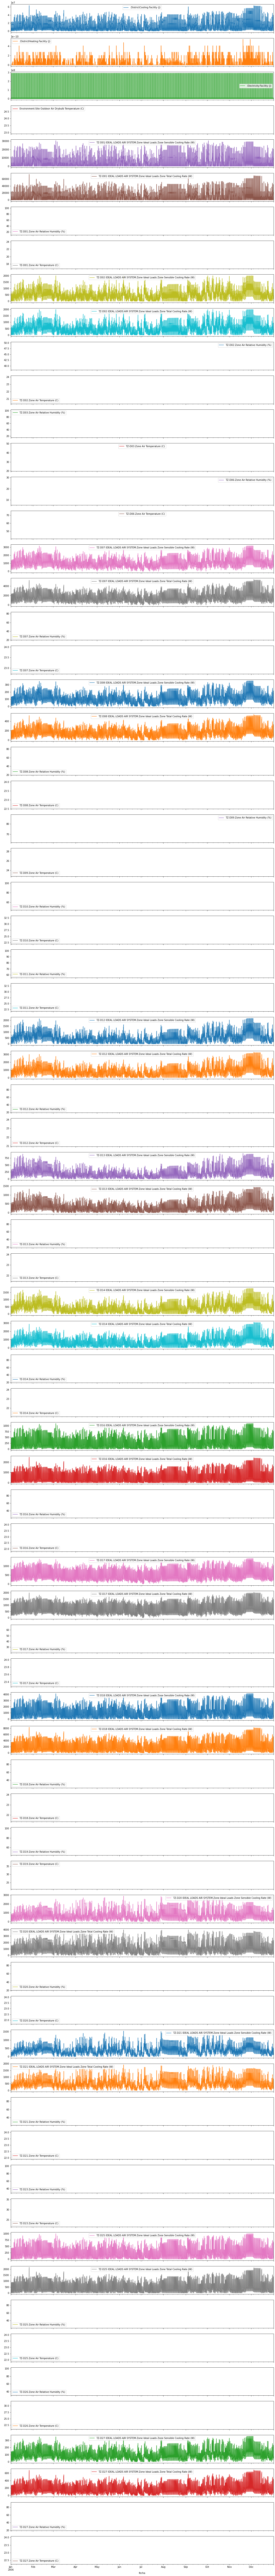

In [9]:
df.plot(subplots=True,figsize = (20,200));
